In [1]:
import sys
import numpy as np
from numpy.random import choice
import random
import matplotlib.pyplot as plt
import copy

In [2]:
class Individuo:
    def __init__(self, dimentions):
        self.dim = dimentions
        self.cromossomo = self.inicializar_individuo()
        self.valor_objetivo = None
        self.aptidao = None
        self.calc_valor_objetivo()
        self.isok = True
        
    def inicializar_individuo(self):
        """
        metodo inicializacao do individuo por uma normal em torno de zero
        """
        return np.random.randn(30)
    
    def calc_valor_objetivo(self):
        """
        metodo calculo valor objetivo
        """
        d_total = sum(list(map(lambda x: x**2 - 10*np.cos(2*np.pi*x) + 10, self.cromossomo)))
        
        self.valor_objetivo = d_total
        if d_total == 0:
            self.aptidao = sys.maxsize
        else:
            self.aptidao = 1 / d_total
        
        return self

In [3]:
class Populacao:
    def __init__(self, tam_populacao, taxa_mutacao, qtd_geracoes, dim, mutar=1, cruzar=1):
        self.individuos = [Individuo(dim) for _ in range(0, tam_populacao)]
        self.tam_populacao = tam_populacao
        self.taxa_mutacao = taxa_mutacao
        self.qtd_geracoes = qtd_geracoes
        self.dim = dim
        self.howtocruzar=cruzar
        self.howtomutar=mutar
        self.historico = []
      
    def mostrar_ind(self, ind):
        """
        mostrar um indivíduo
        """
        print("Valores: " + str(ind.cromossomo) +
              " | Valor objetivo: " + str(ind.valor_objetivo))
    
    def mostrar_populacao(self):
        """
        mostrar a população inteira
        """
        print("------------------------ População Inicial ------------------------")

        for ind in self.individuos:
            self.mostrar_ind(ind)

        print("-------------------------------------------------------------------")
    
    # Método que retorna o melhor indivíduo da população
    def get_melhor_ind(self):
        """
        retorna o melhor indivíduo da população
        """
        melhor_ind = None
        for ind in self.individuos:
            if melhor_ind is None or ind.aptidao > melhor_ind.aptidao:
                melhor_ind = ind

        return melhor_ind
    
    def mutar1(self, ind):
        """
        metodo para mutação de indivíduo, porém baseado na população inteira
        """
        self.individuos = sorted(self.individuos, key=lambda x: x.valor_objetivo, reverse=False)
        
        sizepop = self.tam_populacao
        size = int(sizepop/5) + 1
        random_firsts_indvs = np.random.randint(0, int(sizepop/2), size)
        
        matrix_firsts = np.array(
            list(map(lambda indvi: indvi.cromossomo[:], list(np.array(self.individuos)[random_firsts_indvs]))))
        
        fator = np.random.rand()/10

        random_good_indv = np.random.randint(0, int(sizepop/4))
        random_worst_indv = np.random.randint(3*int(sizepop/4), sizepop)
        
        good_cromo = self.individuos[random_good_indv].cromossomo
        worst_cromo = self.individuos[random_worst_indv].cromossomo
                
        error = np.array(good_cromo) - np.array(worst_cromo) #fator erro, good é a saída ideal, worst a pior, então isso representa o erro
        stoc = fator*matrix_firsts.mean(0) #fator estocástico, médias melhores
        
        ind.cromossomo = (error + stoc)/2 # Controle P
        
        return ind.calc_valor_objetivo()     
            
    def mutar2(self, ind):
        self.individuos = sorted(self.individuos, key=lambda x: x.valor_objetivo, reverse=False)
        
        sizepop = self.tam_populacao
        size = int(sizepop/5) + 1
        random_firsts_indvs = np.random.randint(0, int(sizepop/2), size)
        
        matrix_firsts = np.array(
            list(map(lambda indvi: indvi.cromossomo[:], list(np.array(self.individuos)[random_firsts_indvs]))))
        
        fator = np.random.rand()/10

        random_good_indv = np.random.randint(0, int(sizepop/4))
        random_worst_indv = np.random.randint(3*int(sizepop/4), sizepop)
        
        good_cromo = self.individuos[random_good_indv].cromossomo
        worst_cromo = self.individuos[random_worst_indv].cromossomo
                
        error = np.array(good_cromo) - np.array(worst_cromo) #fator erro, good é a saída ideal, worst a pior, então isso representa o erro
        
        ind.cromossomo = (ind.cromossomo + error)/2 # sem fator estocástico
        
        return ind.calc_valor_objetivo()    
    
    def cruzamento(self, ind_mutado, ind_original, prob_cruz):
        """
        cruzamento geral. é feito misturando cromossomos de 2 individuos. um mutado e um original.
        """
        ind_fixo = random.randint(0, int(self.tam_populacao/4))
        novo_cromossomo = []
        dimention = ind_mutado.dim
        
        for i in range(0, dimention):
            r = random.random()
            if i == ind_fixo or np.random.rand() <= prob_cruz:
                novo_cromossomo.append(ind_mutado.cromossomo[i])
            else:
                novo_cromossomo.append(ind_original.cromossomo[i])

        novo_ind = Individuo(self.dim)
        novo_ind.cromossomo = novo_cromossomo
        
        return novo_ind.calc_valor_objetivo()
    
    def reproducao1(self):
        """
        roleta
        """
        descendentes = []
        
        for i in range(0, self.tam_populacao):
            
            to_remove_prob = list(np.isnan(np.array(list(map(lambda x: x.aptidao, self.individuos)))))
            filtered_indvs=[]
            for index, indiv in enumerate(self.individuos):
                if index not in to_remove_prob:
                    filtered_indvs.append(self.individuos[index])
                        
            soma_aptidoes = sum([ind.aptidao for ind in filtered_indvs])
            distribuicao_probabilidade = np.array([ind.aptidao / soma_aptidoes for ind in filtered_indvs])
            
            [ind_1, ind_2] = choice(filtered_indvs, 2, p=distribuicao_probabilidade, replace=False)
                
            if self.howtomutar == 1:
                [ind_1, ind_2] = [self.mutar1(ind_1), ind_2]
            else:
                [ind_1, ind_2] = [self.mutar2(ind_1), ind_2]
            
            novo_ind = self.cruzamento(ind_1, ind_2, self.taxa_mutacao)
            
            novo_ind.calc_valor_objetivo()
            descendentes.append(novo_ind)

        return descendentes
    
    def reproducao2(self):
        """
        torneio
        """
        descendentes = []
        sorted_individuos = sorted(self.individuos, key=lambda x: x.valor_objetivo, reverse=False)        
        prob_cruz = 0
        for i in range(0, self.tam_populacao):
            i2 = i+1
            if i2 >= self.tam_populacao:
                i2 = self.tam_populacao-1
                            
            [ind_1, ind_2] = choice(sorted_individuos, 2, replace=False)
            [ind_3, ind_4] = choice(sorted_individuos, 2, replace=False)
            
            if ind_1.aptidao > ind_2.aptidao:
                winner1 = ind_1
            else:
                winner1 = ind_2
            
            if ind_3.aptidao > ind_4.aptidao:
                winner2 = ind_3
            else:
                winner2 = ind_4
            
            if self.howtomutar == 1:
                [winner1, winner2] = [self.mutar1(winner1), winner2]
            else:
                [winner1, winner2] = [self.mutar2(winner1), winner2]
            
            novo_ind = self.cruzamento(winner1, winner2, prob_cruz)
            
            novo_ind.calc_valor_objetivo()
            descendentes.append(novo_ind)
            
            prob_cruz += 1/self.tam_populacao
            
        return descendentes
    
    def reproducao3(self):
        """
        elitismo aleatorio
        """
        descendentes = []
        sorted_individuos = sorted(self.individuos, key=lambda x: x.valor_objetivo, reverse=False)
        prob_cruz = 0
        for i in range(0, self.tam_populacao):
            if i < np.random.randint(1, self.tam_populacao):
                descendentes.append(sorted_individuos[i])
            else:
                i2 = i+1
                if i2 >= self.tam_populacao:
                    i2 = self.tam_populacao-1
                    
                [ind_1, ind_2] = [sorted_individuos[i], sorted_individuos[i2]]
                
                if self.howtomutar == 1:
                    [ind_1, ind_2] = [self.mutar1(ind_1), ind_2]
                else:
                    [ind_1, ind_2] = [self.mutar2(ind_1), ind_2]
            
                novo_ind = self.cruzamento(ind_1, ind_2, prob_cruz)

                novo_ind.calc_valor_objetivo()
                
                descendentes.append(novo_ind)
                
                prob_cruz += 1/self.tam_populacao

        return descendentes
    
    def train(self, verbose=False):
        alltimeMelhor = None
        
        for i in range(0, self.qtd_geracoes):
            genMelhor = self.get_melhor_ind()
            
            if alltimeMelhor is None or alltimeMelhor.aptidao < genMelhor.aptidao:
                alltimeMelhor = copy.copy(genMelhor)
        
            self.historico.append(genMelhor)
            
            if verbose:
                print("\n------------------- Geração " + str(i + 1) + "-------------------")
                print("\n------------------- Melhor " + str(i + 1) + "-------------------")
                self.mostrar_ind(genMelhor)
                #self.mostrar_populacao()
            
            if self.howtocruzar == "roleta":
                descendentes = self.reproducao1()
            elif self.howtocruzar == "torneio":
                descendentes = self.reproducao2()
            elif self.howtocruzar == "elitismo":
                descendentes = self.reproducao3()
                            
            self.individuos = descendentes

In [4]:
dim = 30
tam_pop = 20
taxa_mut = 0.5
qt_gen = 50
xticks = np.arange(1,qt_gen+1,1)

## Teste Cruzar roleta - Mutar1

In [5]:
populacao_t1 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         dim=dim,mutar=1, cruzar="roleta")
#populacao.mostrar_populacao()
populacao_t1.train(False)

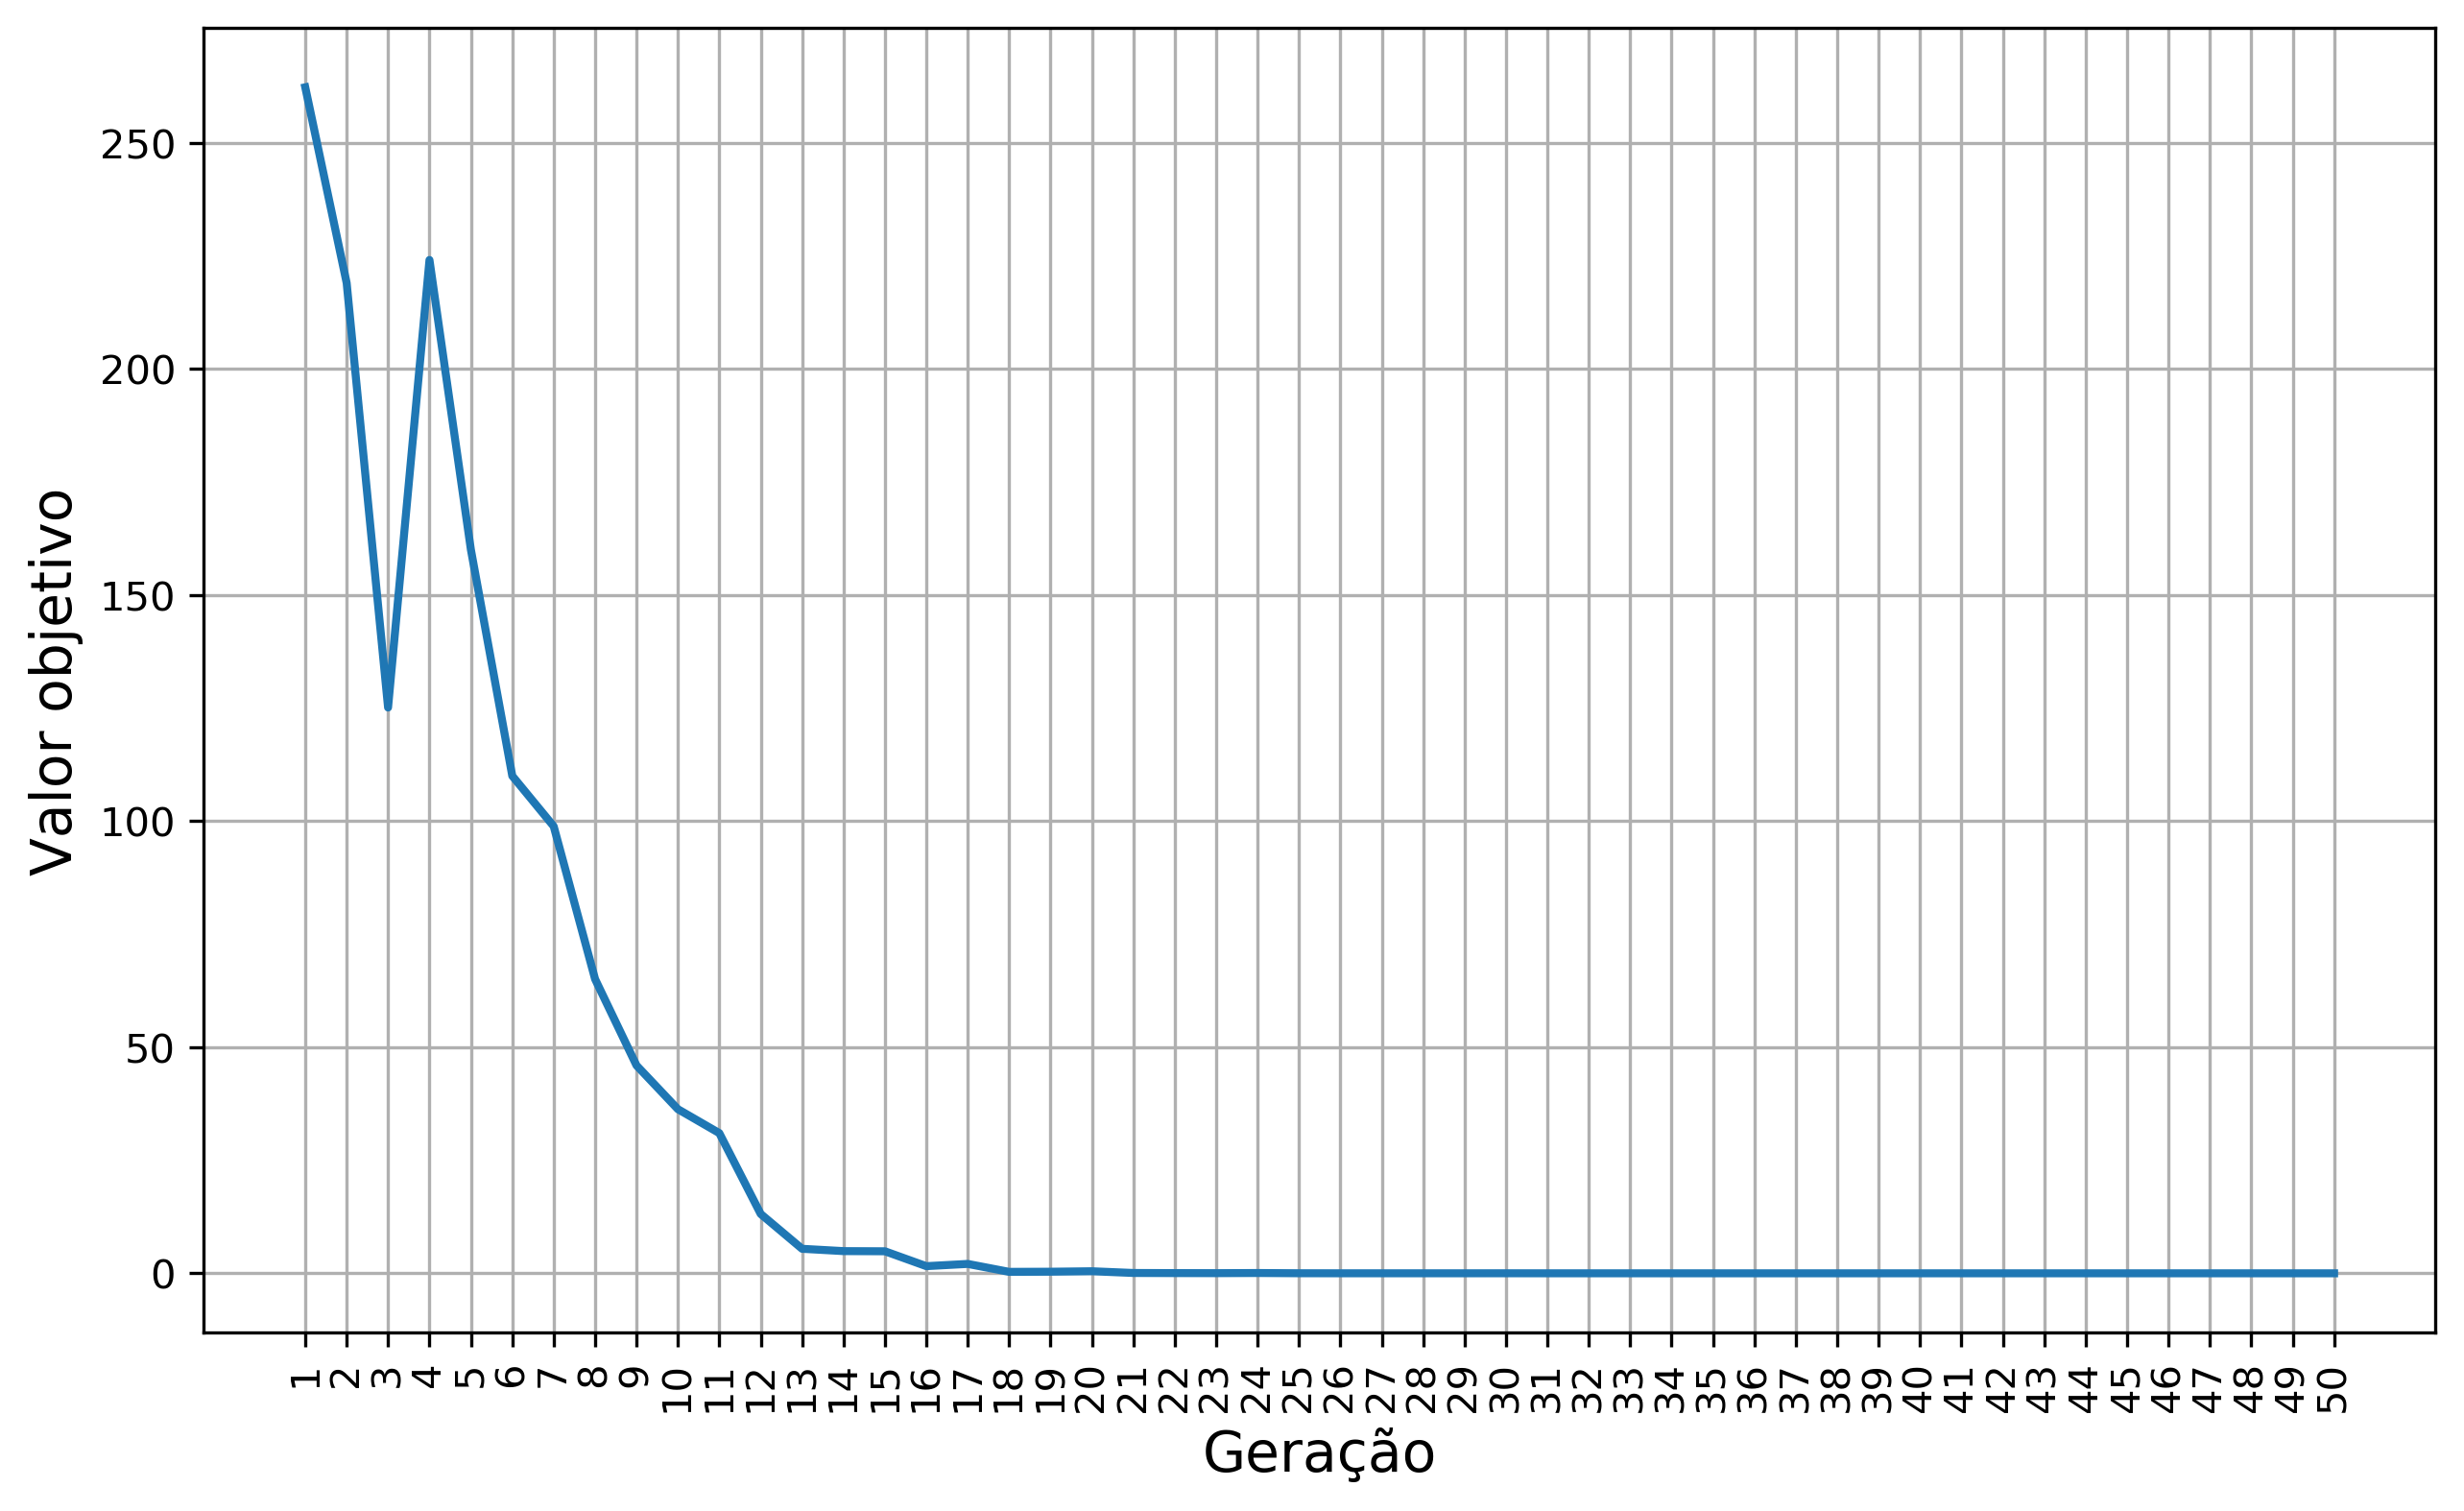

In [6]:
hist_fit_t1 = list(map(lambda x: x.valor_objetivo, populacao_t1.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t1, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar torneio - Mutar1

In [7]:
populacao_t2 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         dim=dim,mutar=1, cruzar="torneio")
#populacao.mostrar_populacao()
populacao_t2.train()

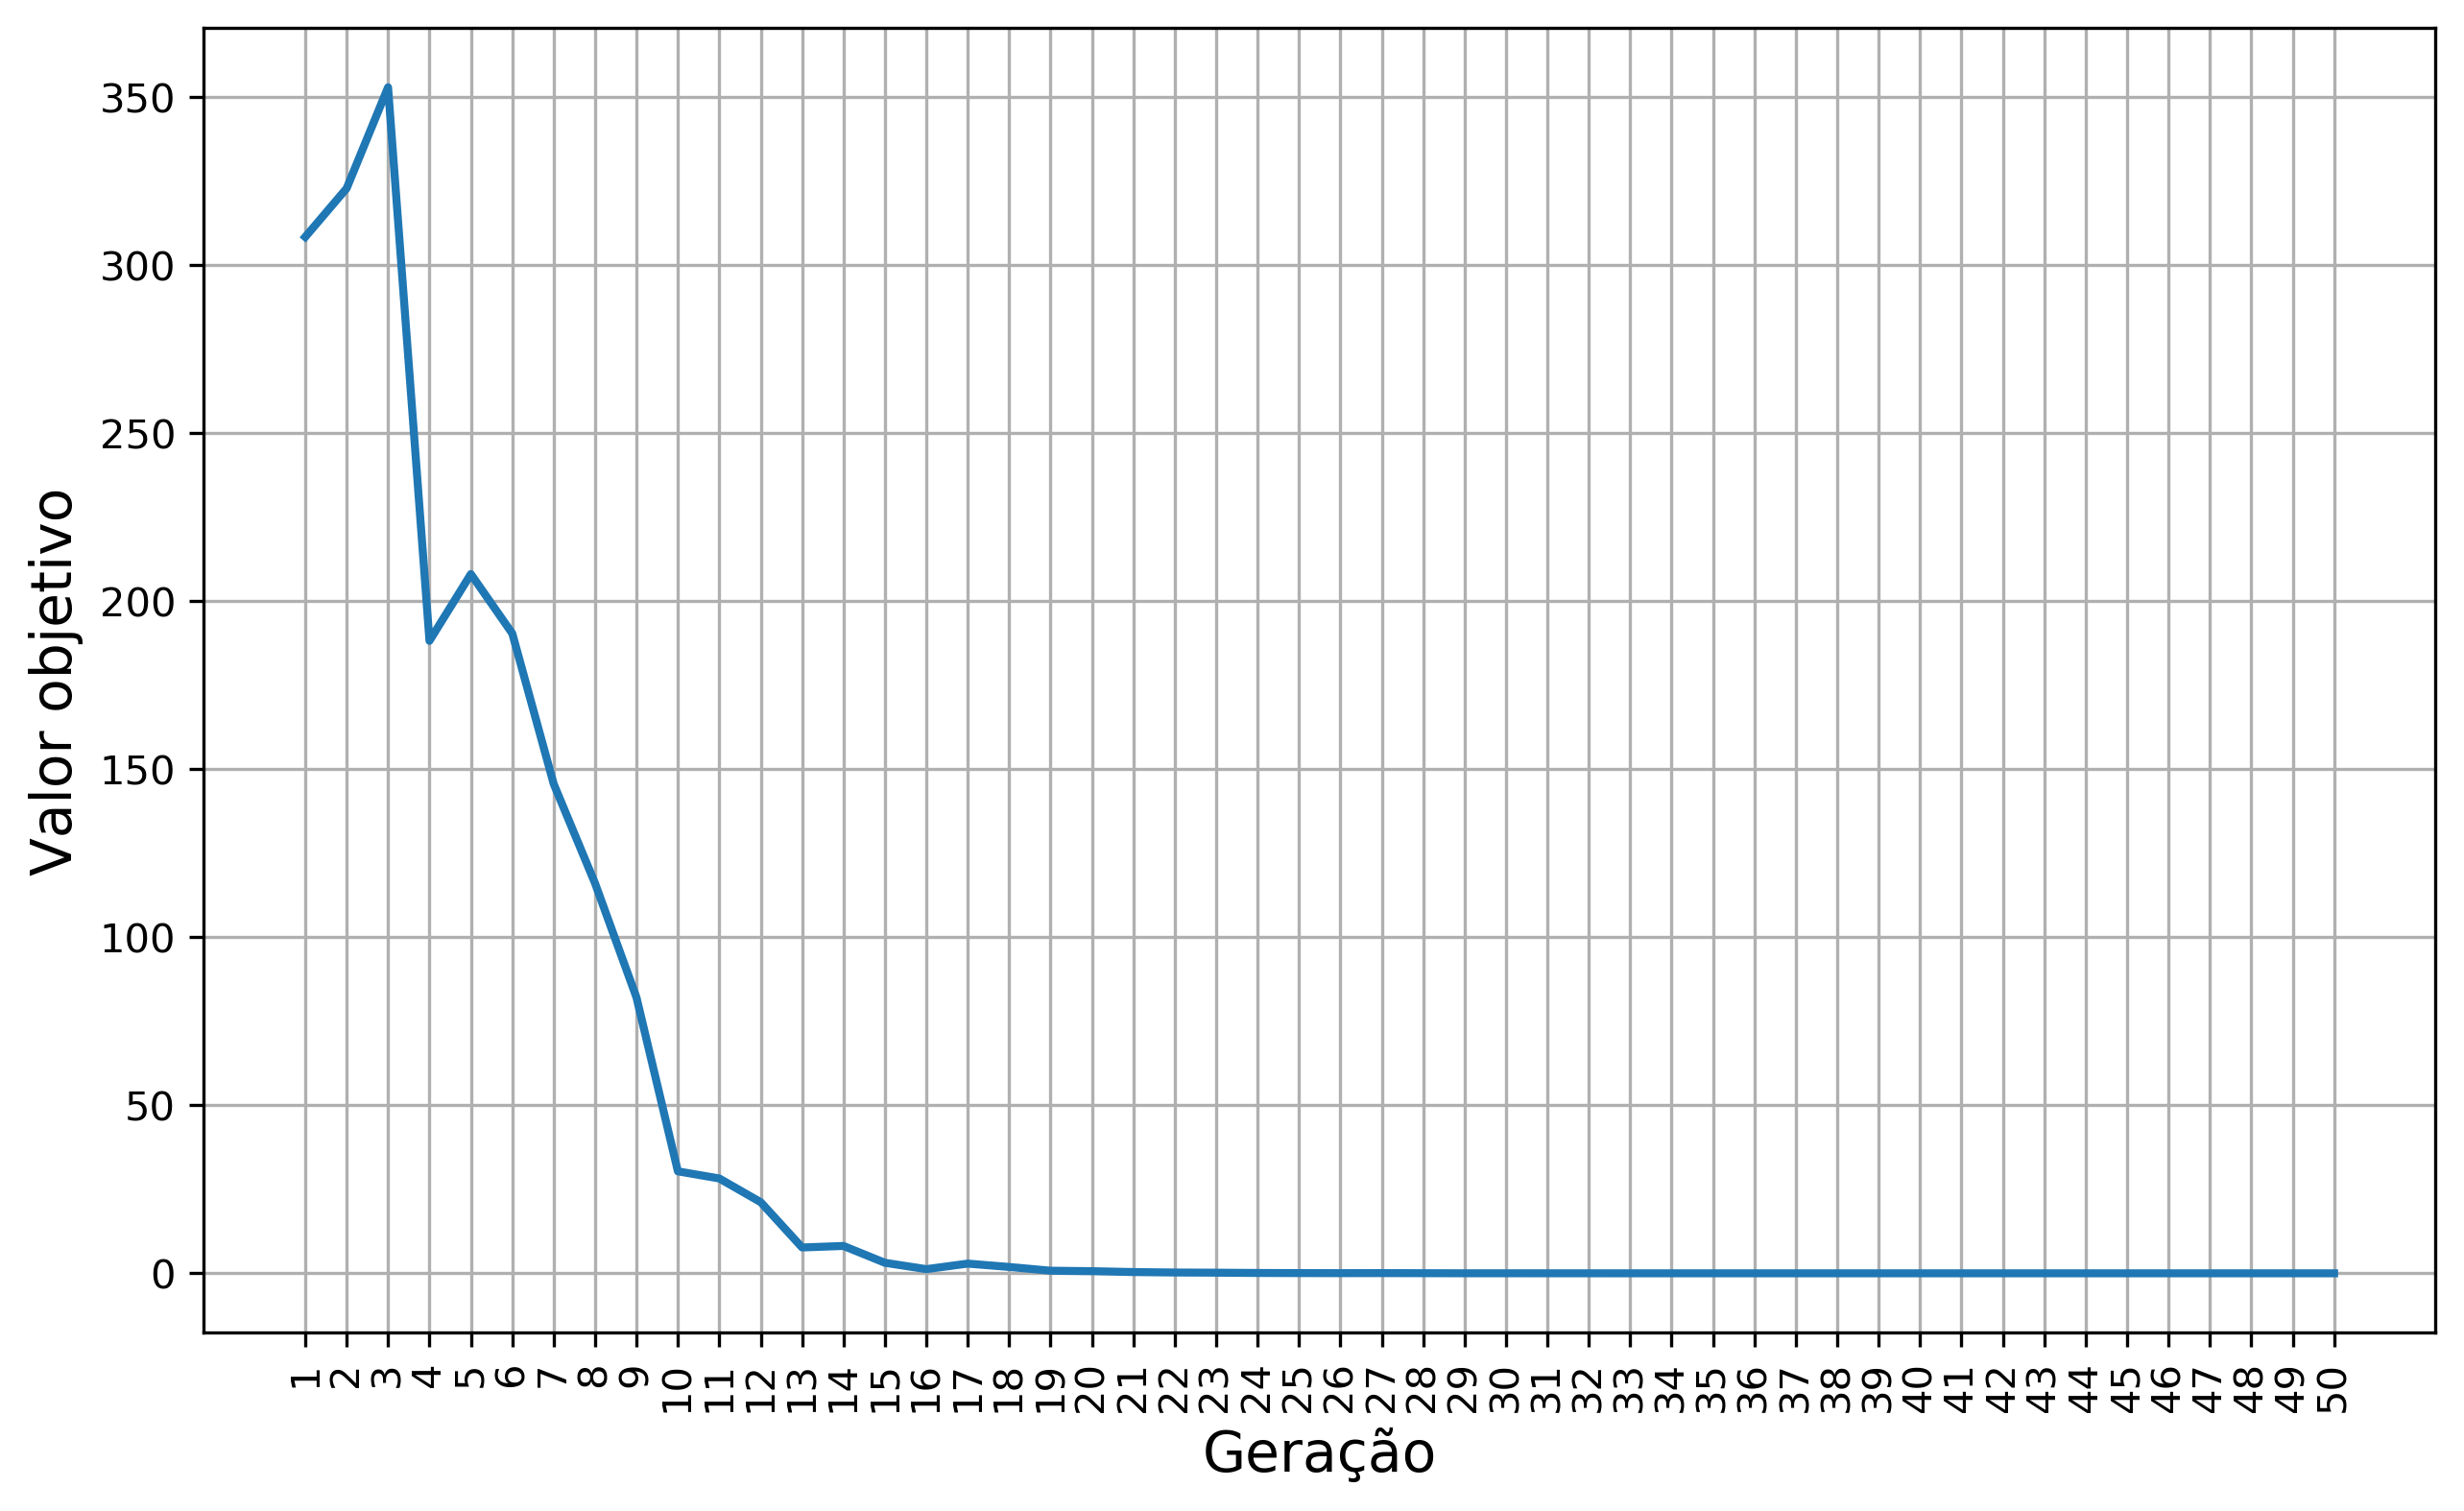

In [8]:
hist_fit_t2 = list(map(lambda x: x.valor_objetivo, populacao_t2.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t2, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar elitismo - Mutar1

In [9]:
populacao_t3 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         dim=dim, mutar=1, cruzar="elitismo")
#populacao.mostrar_populacao()
populacao_t3.train()

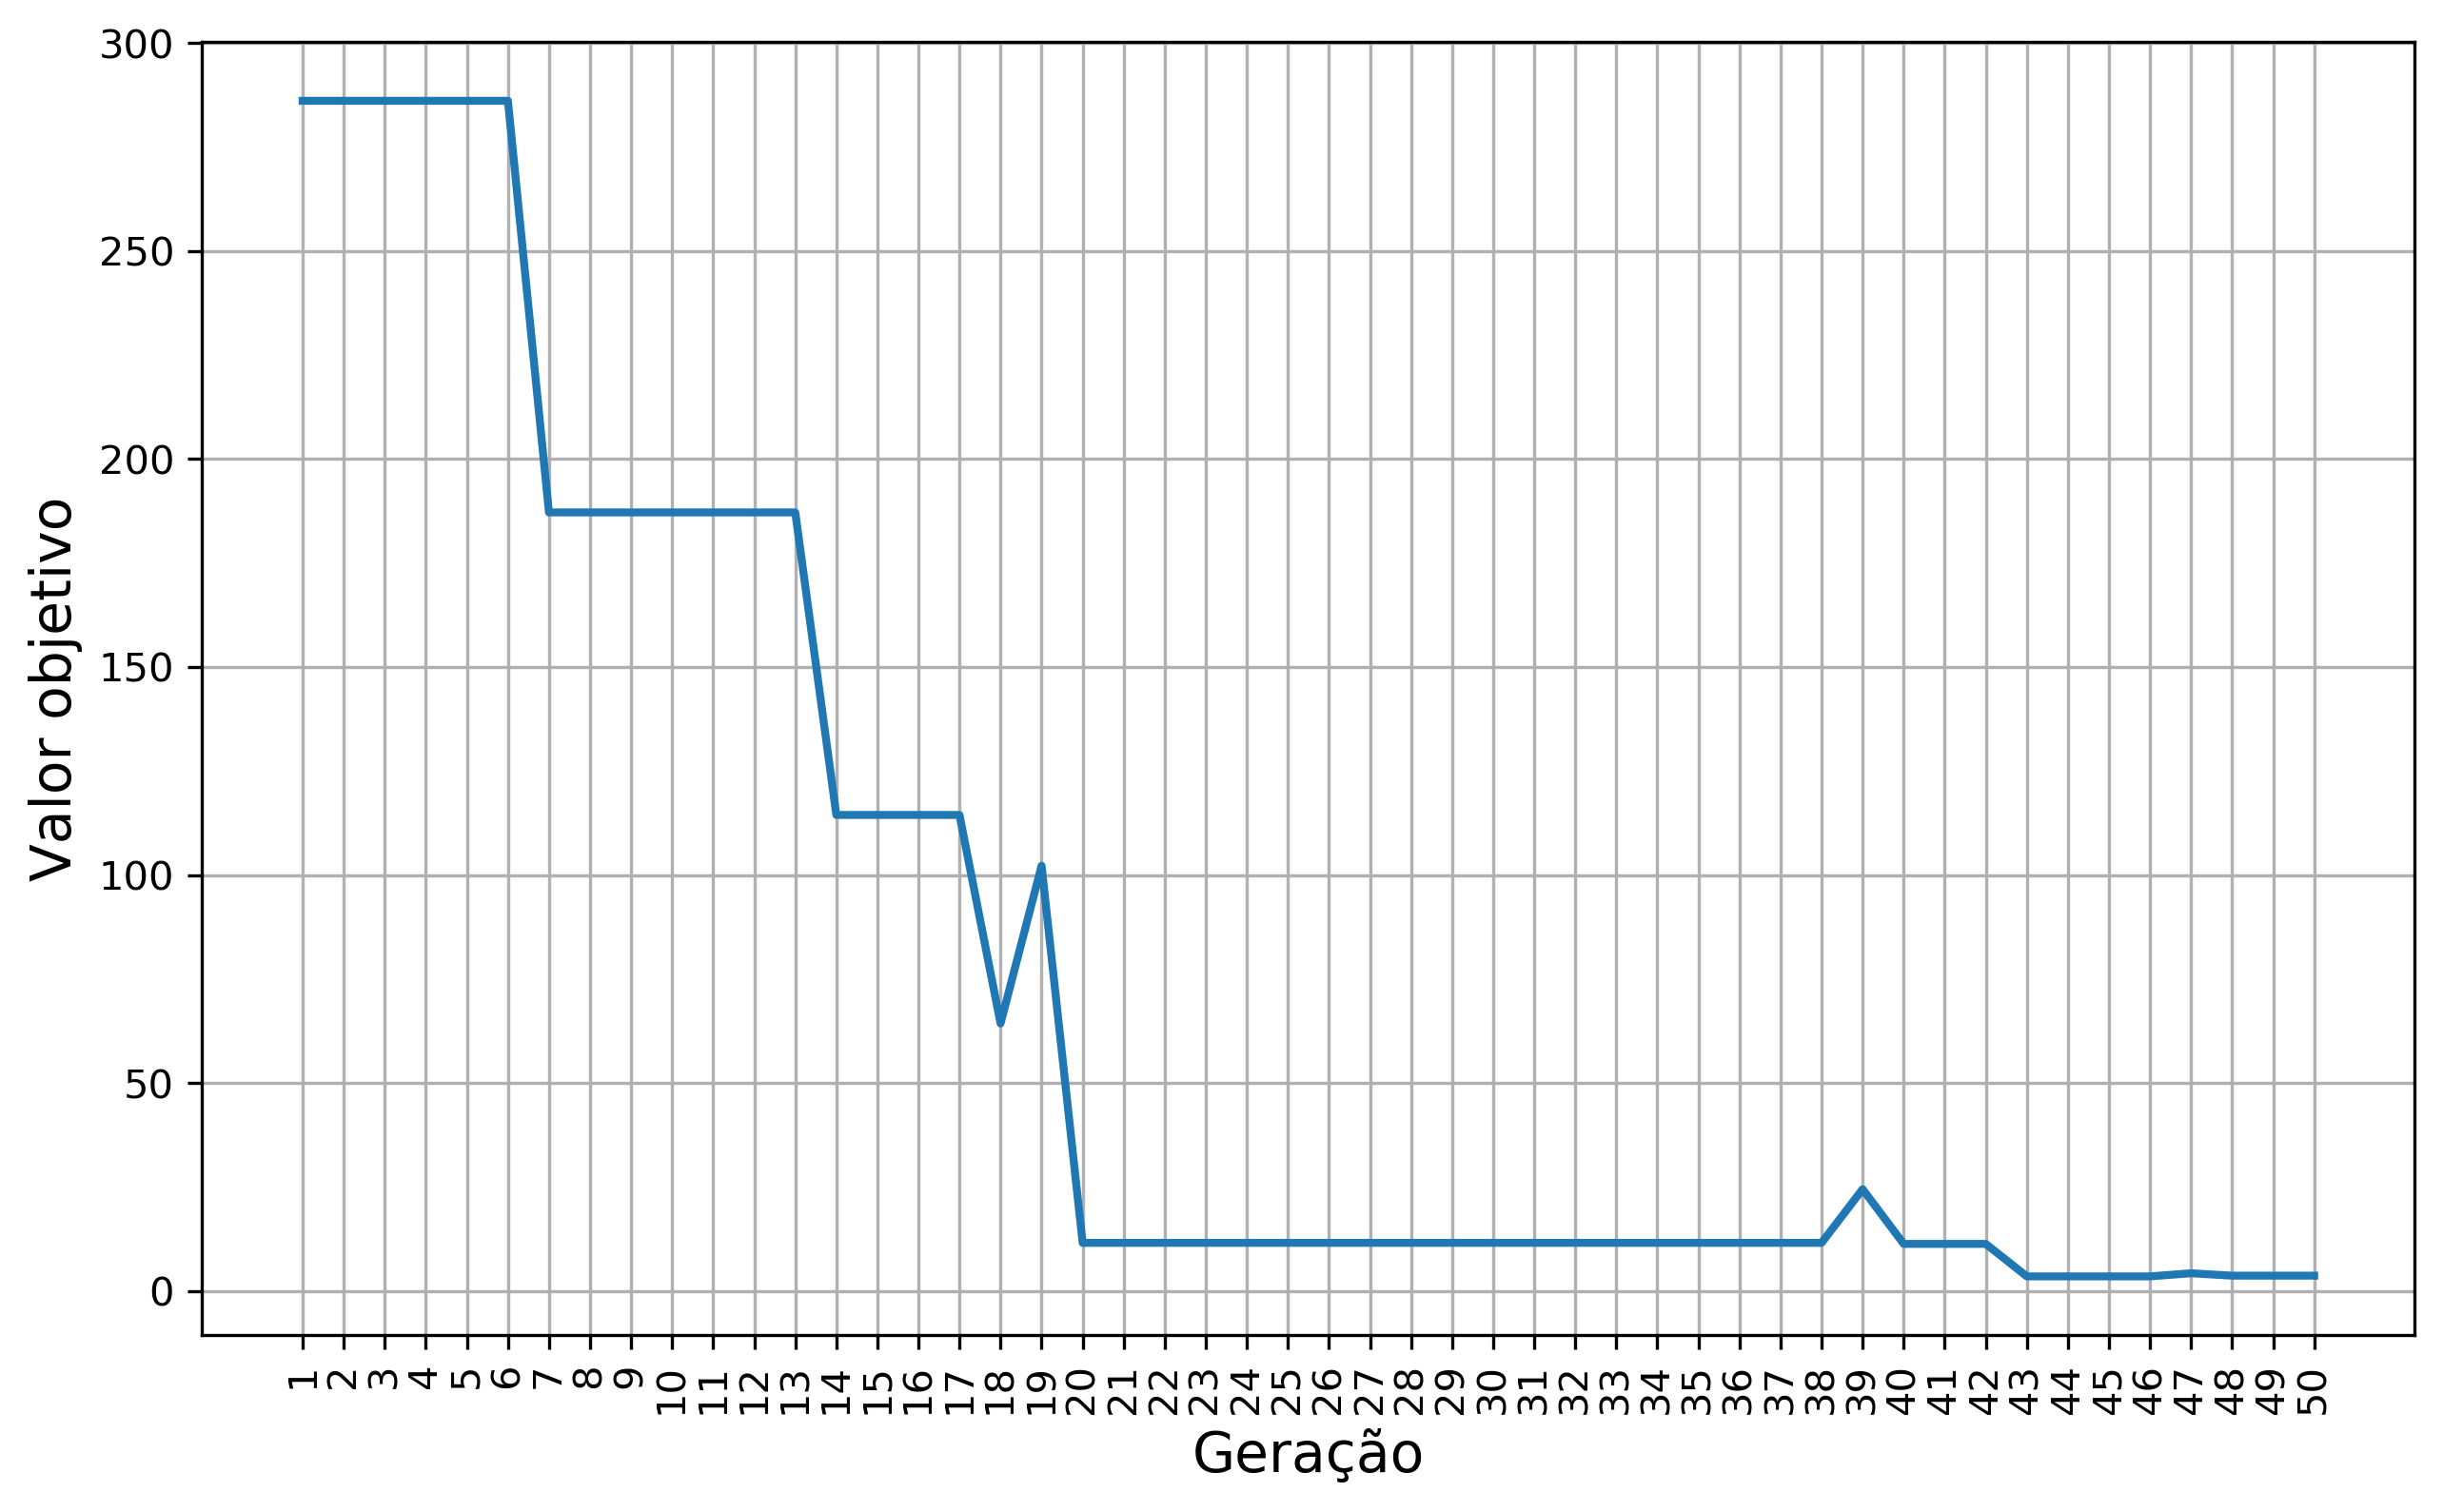

In [10]:
hist_fit_t3 = list(map(lambda x: x.valor_objetivo, populacao_t3.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t3, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar roleta - Mutar2

In [11]:
populacao_t4 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         dim=dim, mutar=2, cruzar="roleta")
#populacao.mostrar_populacao()
populacao_t4.train()

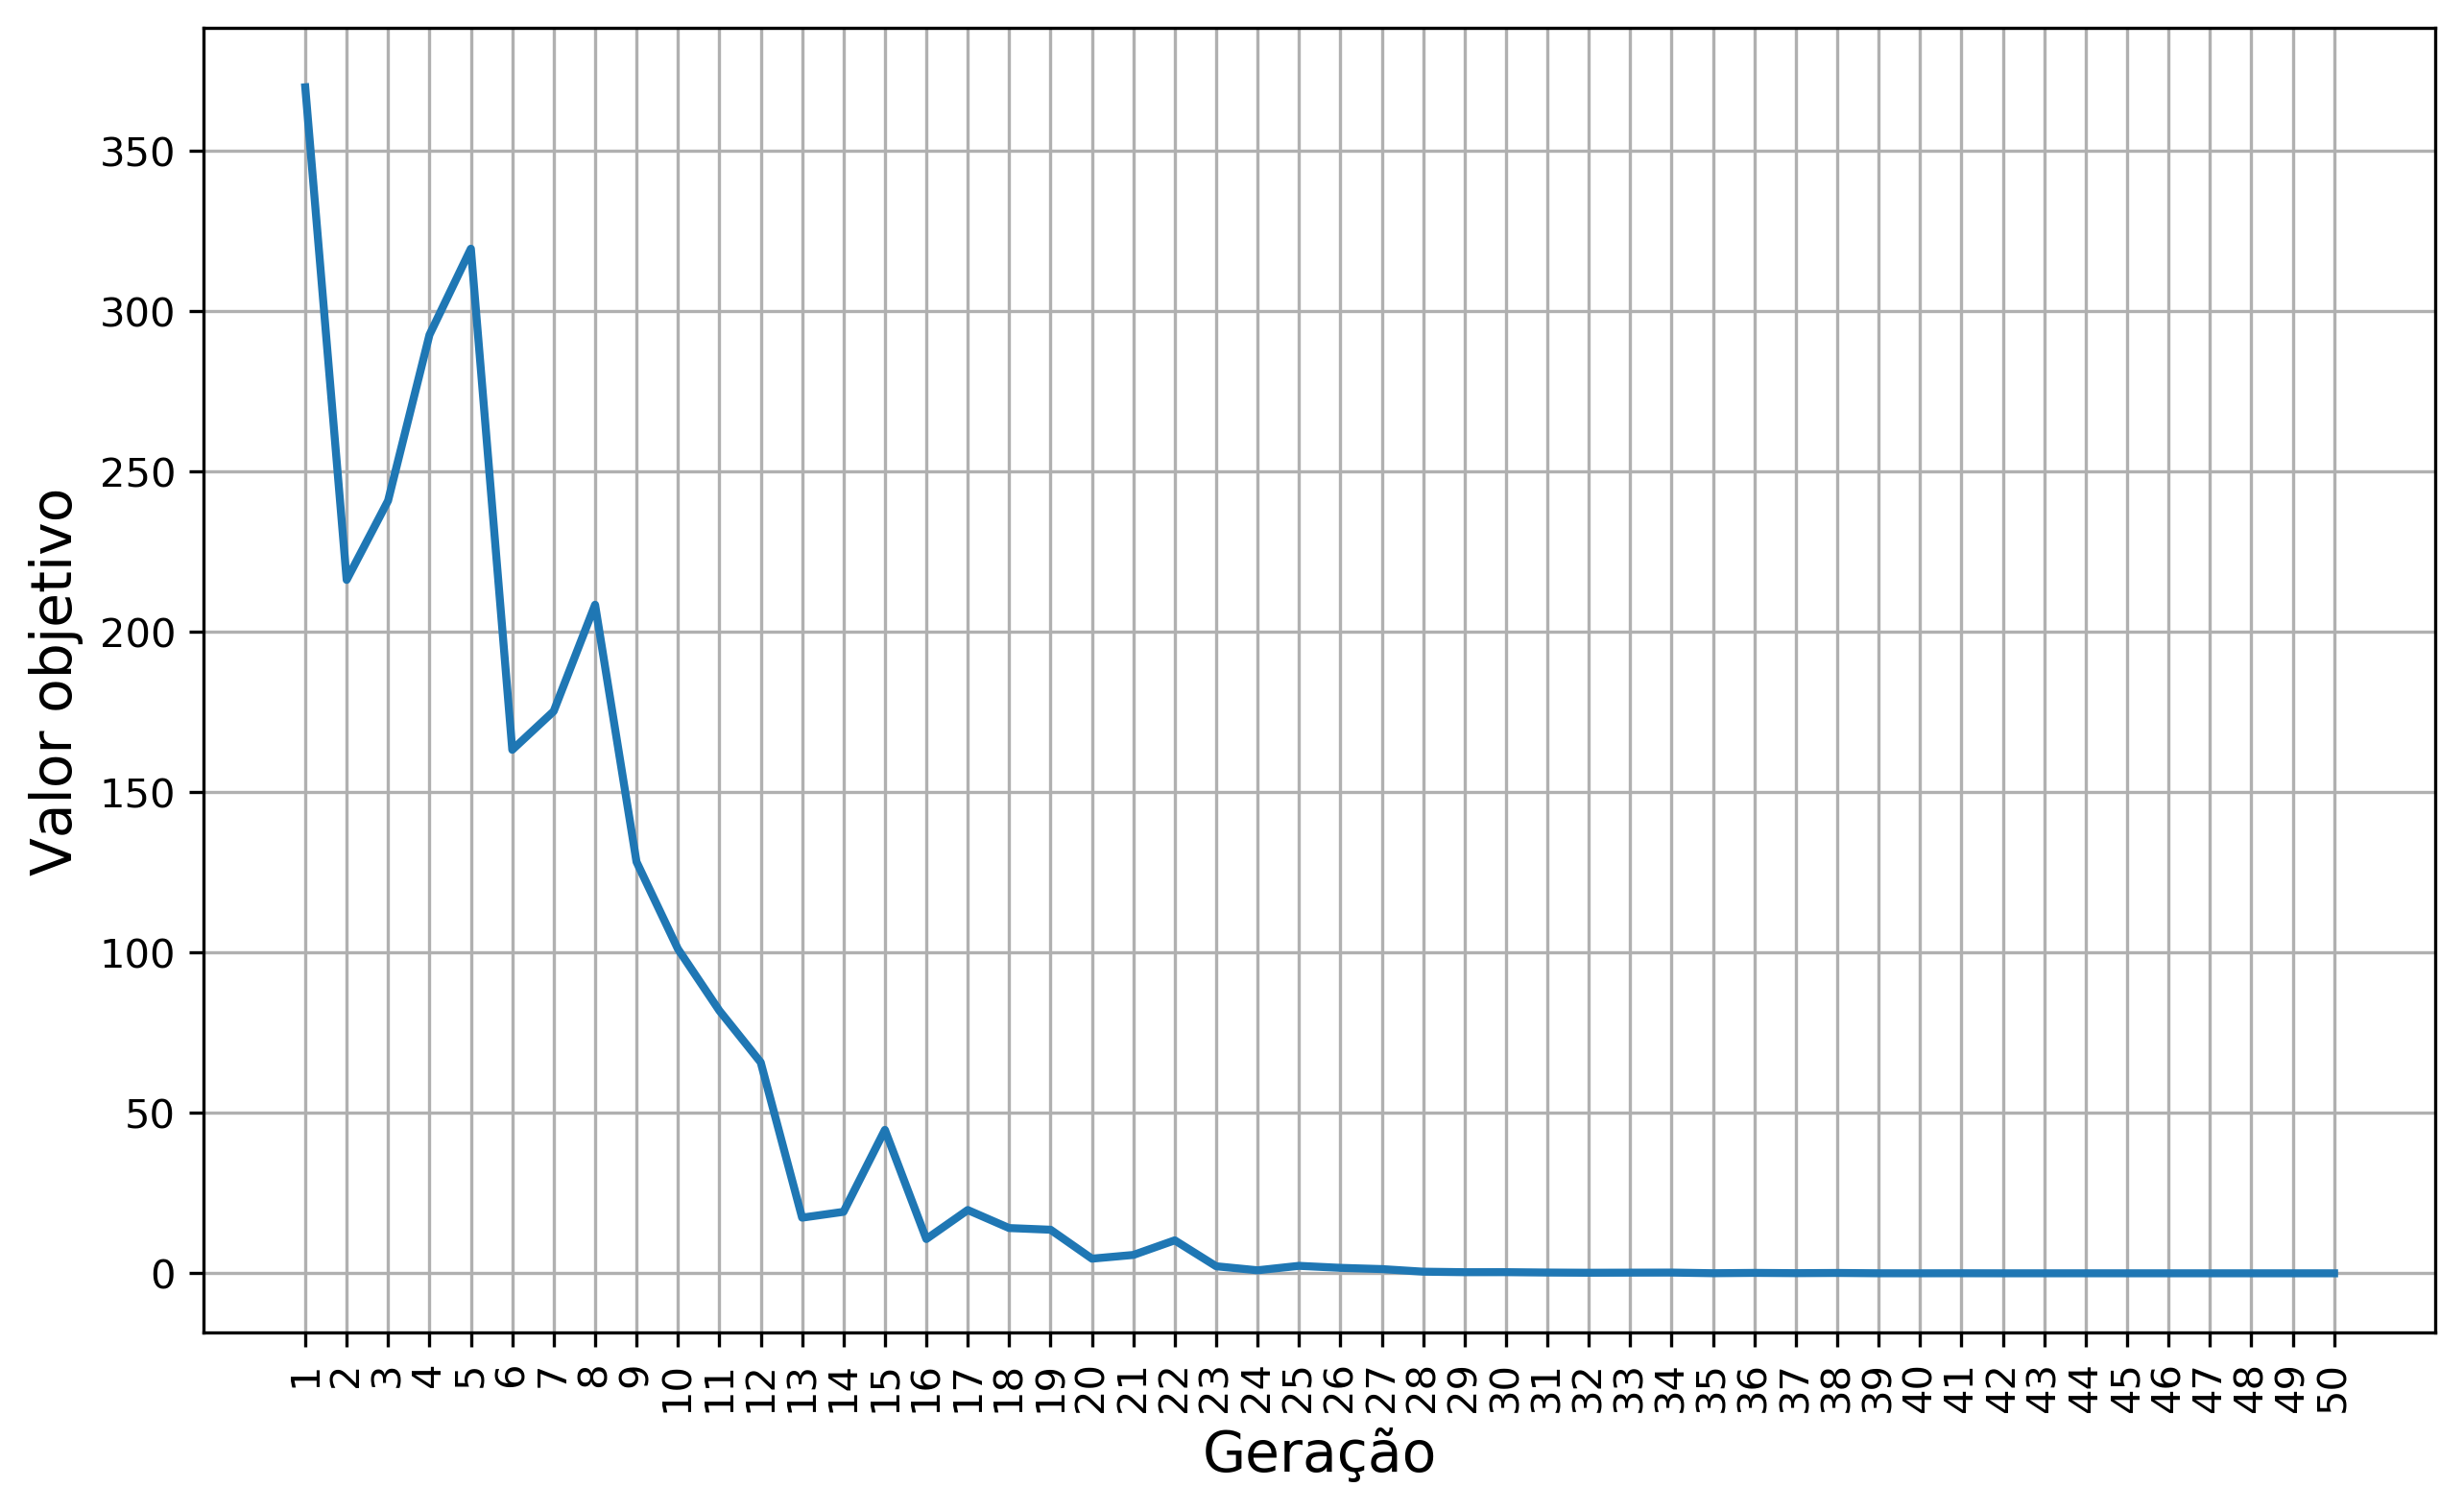

In [12]:
hist_fit_t4 = list(map(lambda x: x.valor_objetivo, populacao_t4.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t4, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar torneio - Mutar2

In [13]:
populacao_t5 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         dim=dim, mutar=2, cruzar="torneio")
#populacao.mostrar_populacao()
populacao_t5.train()

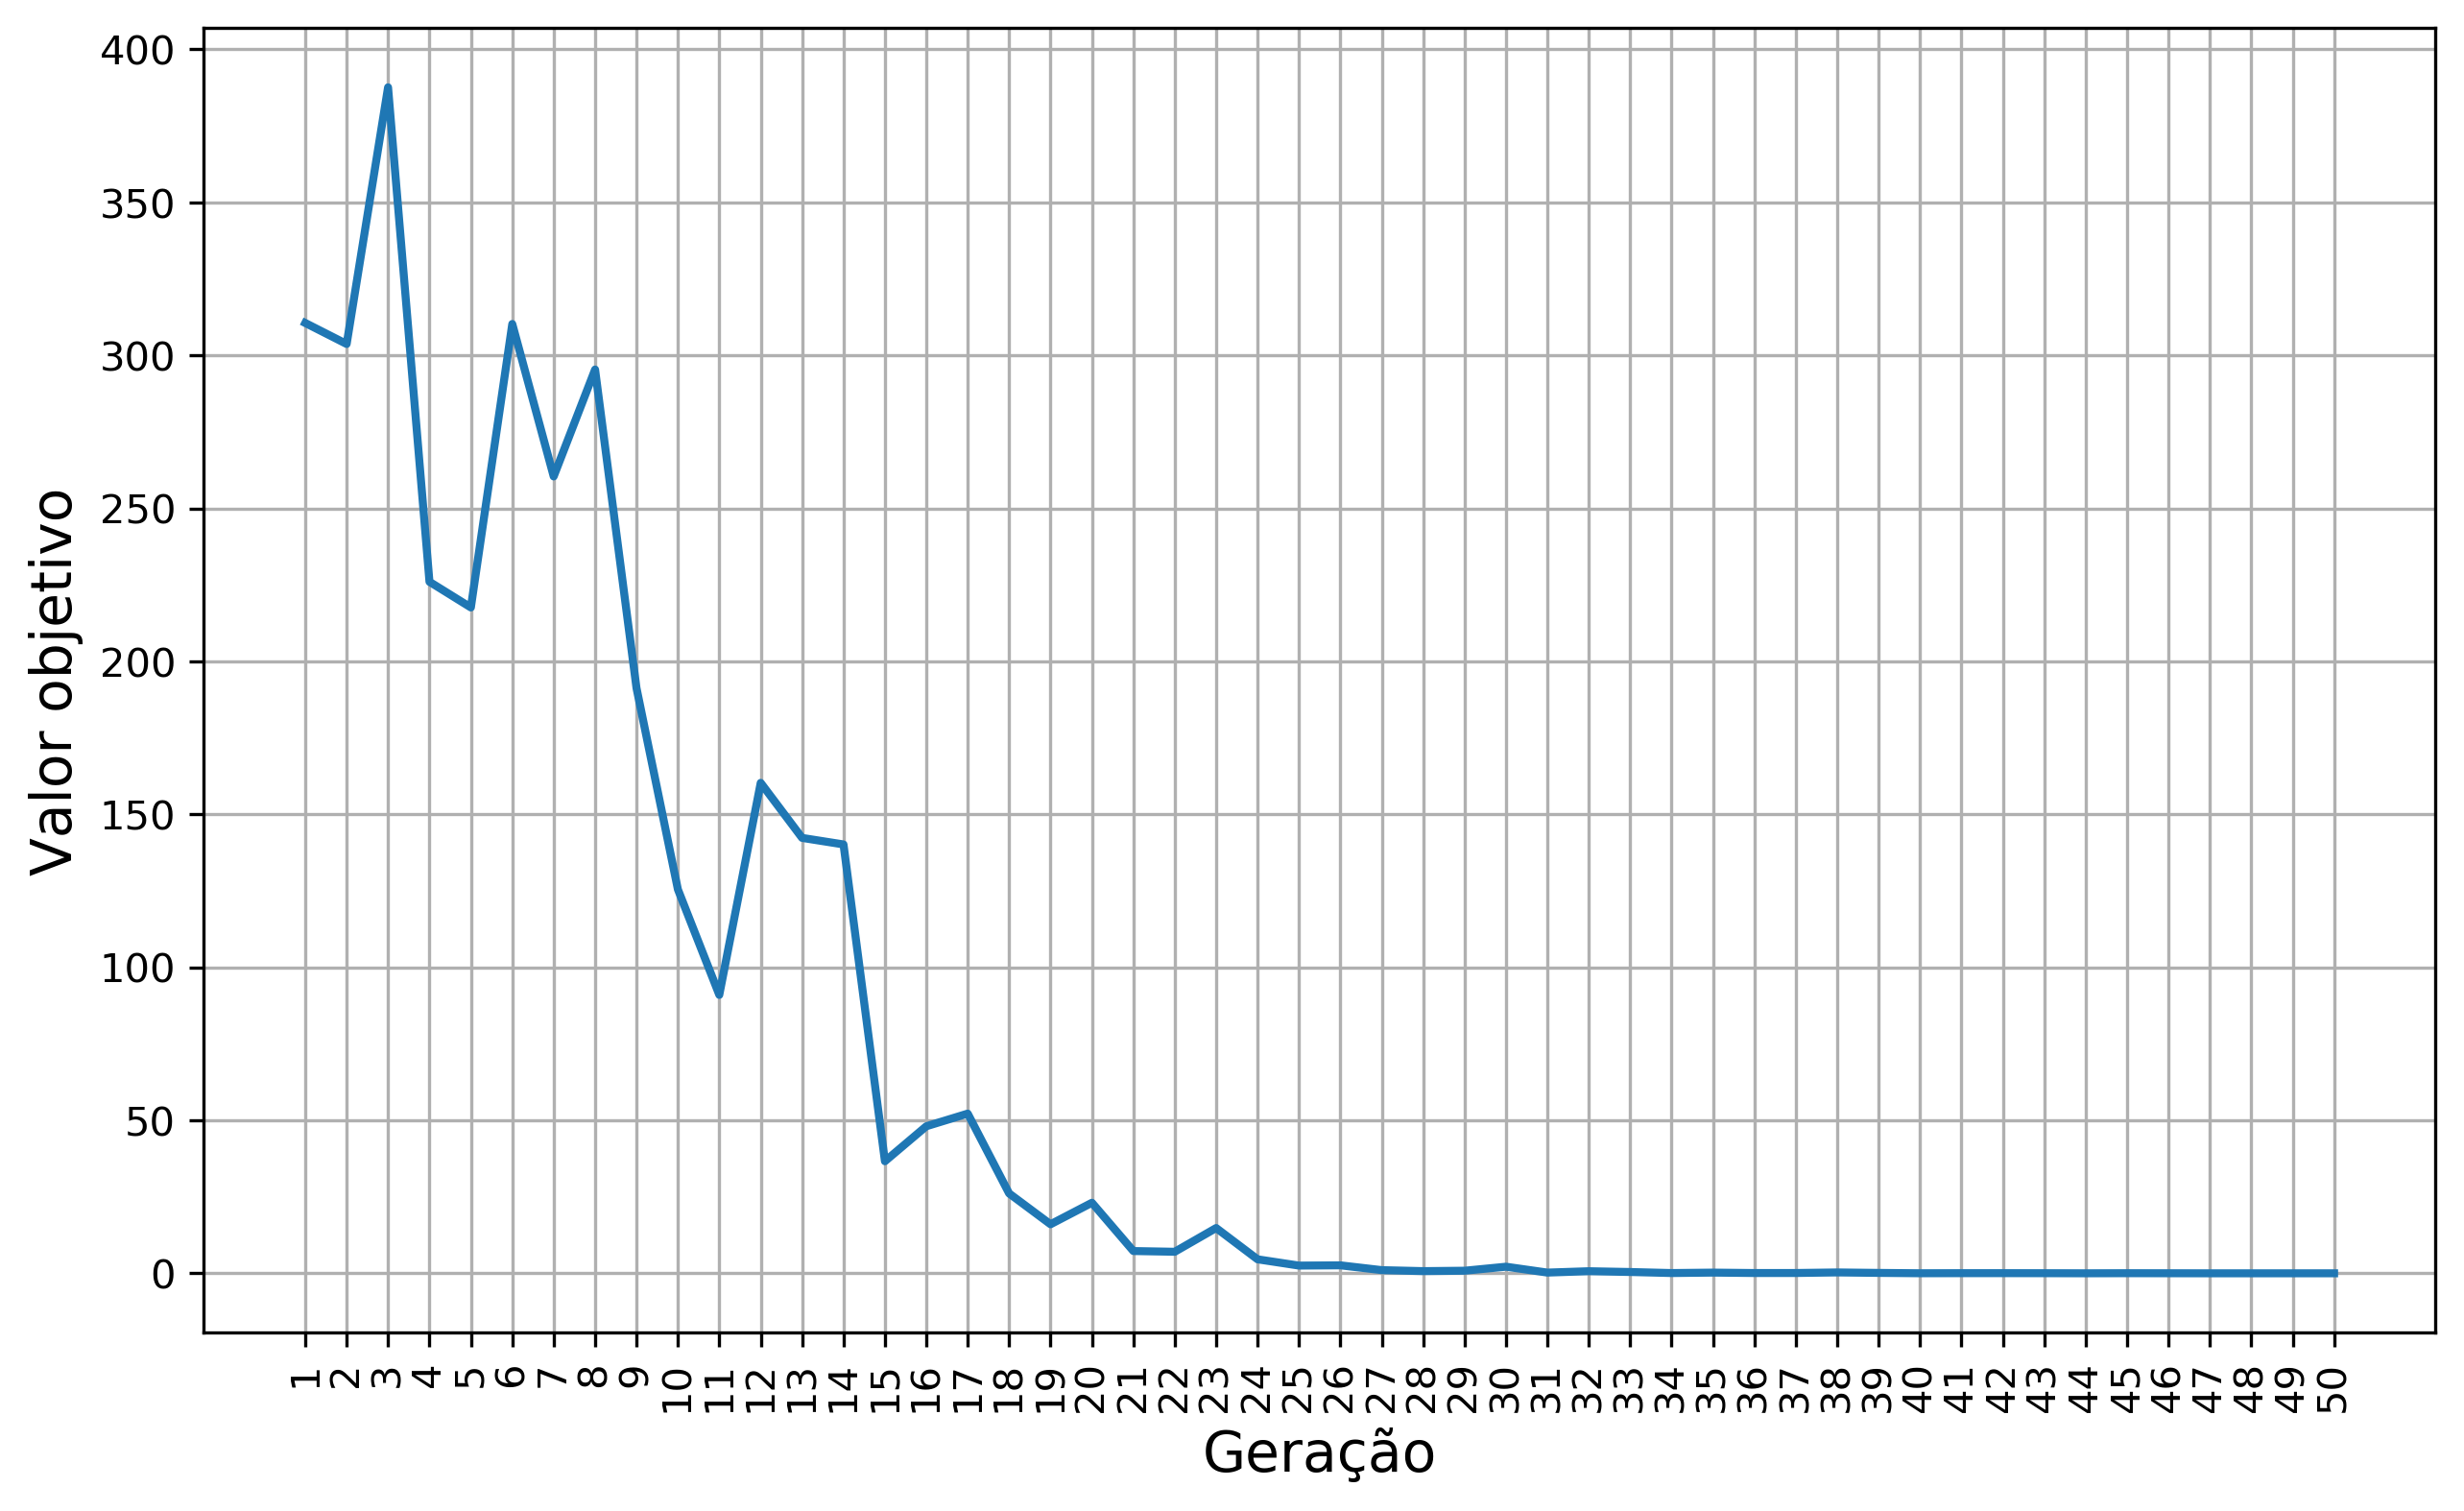

In [14]:
hist_fit_t5 = list(map(lambda x: x.valor_objetivo, populacao_t5.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t5, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar elitismo - Mutar2

In [15]:
populacao_t6 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         dim=dim, mutar=2, cruzar="elitismo")
#populacao.mostrar_populacao()
populacao_t6.train()

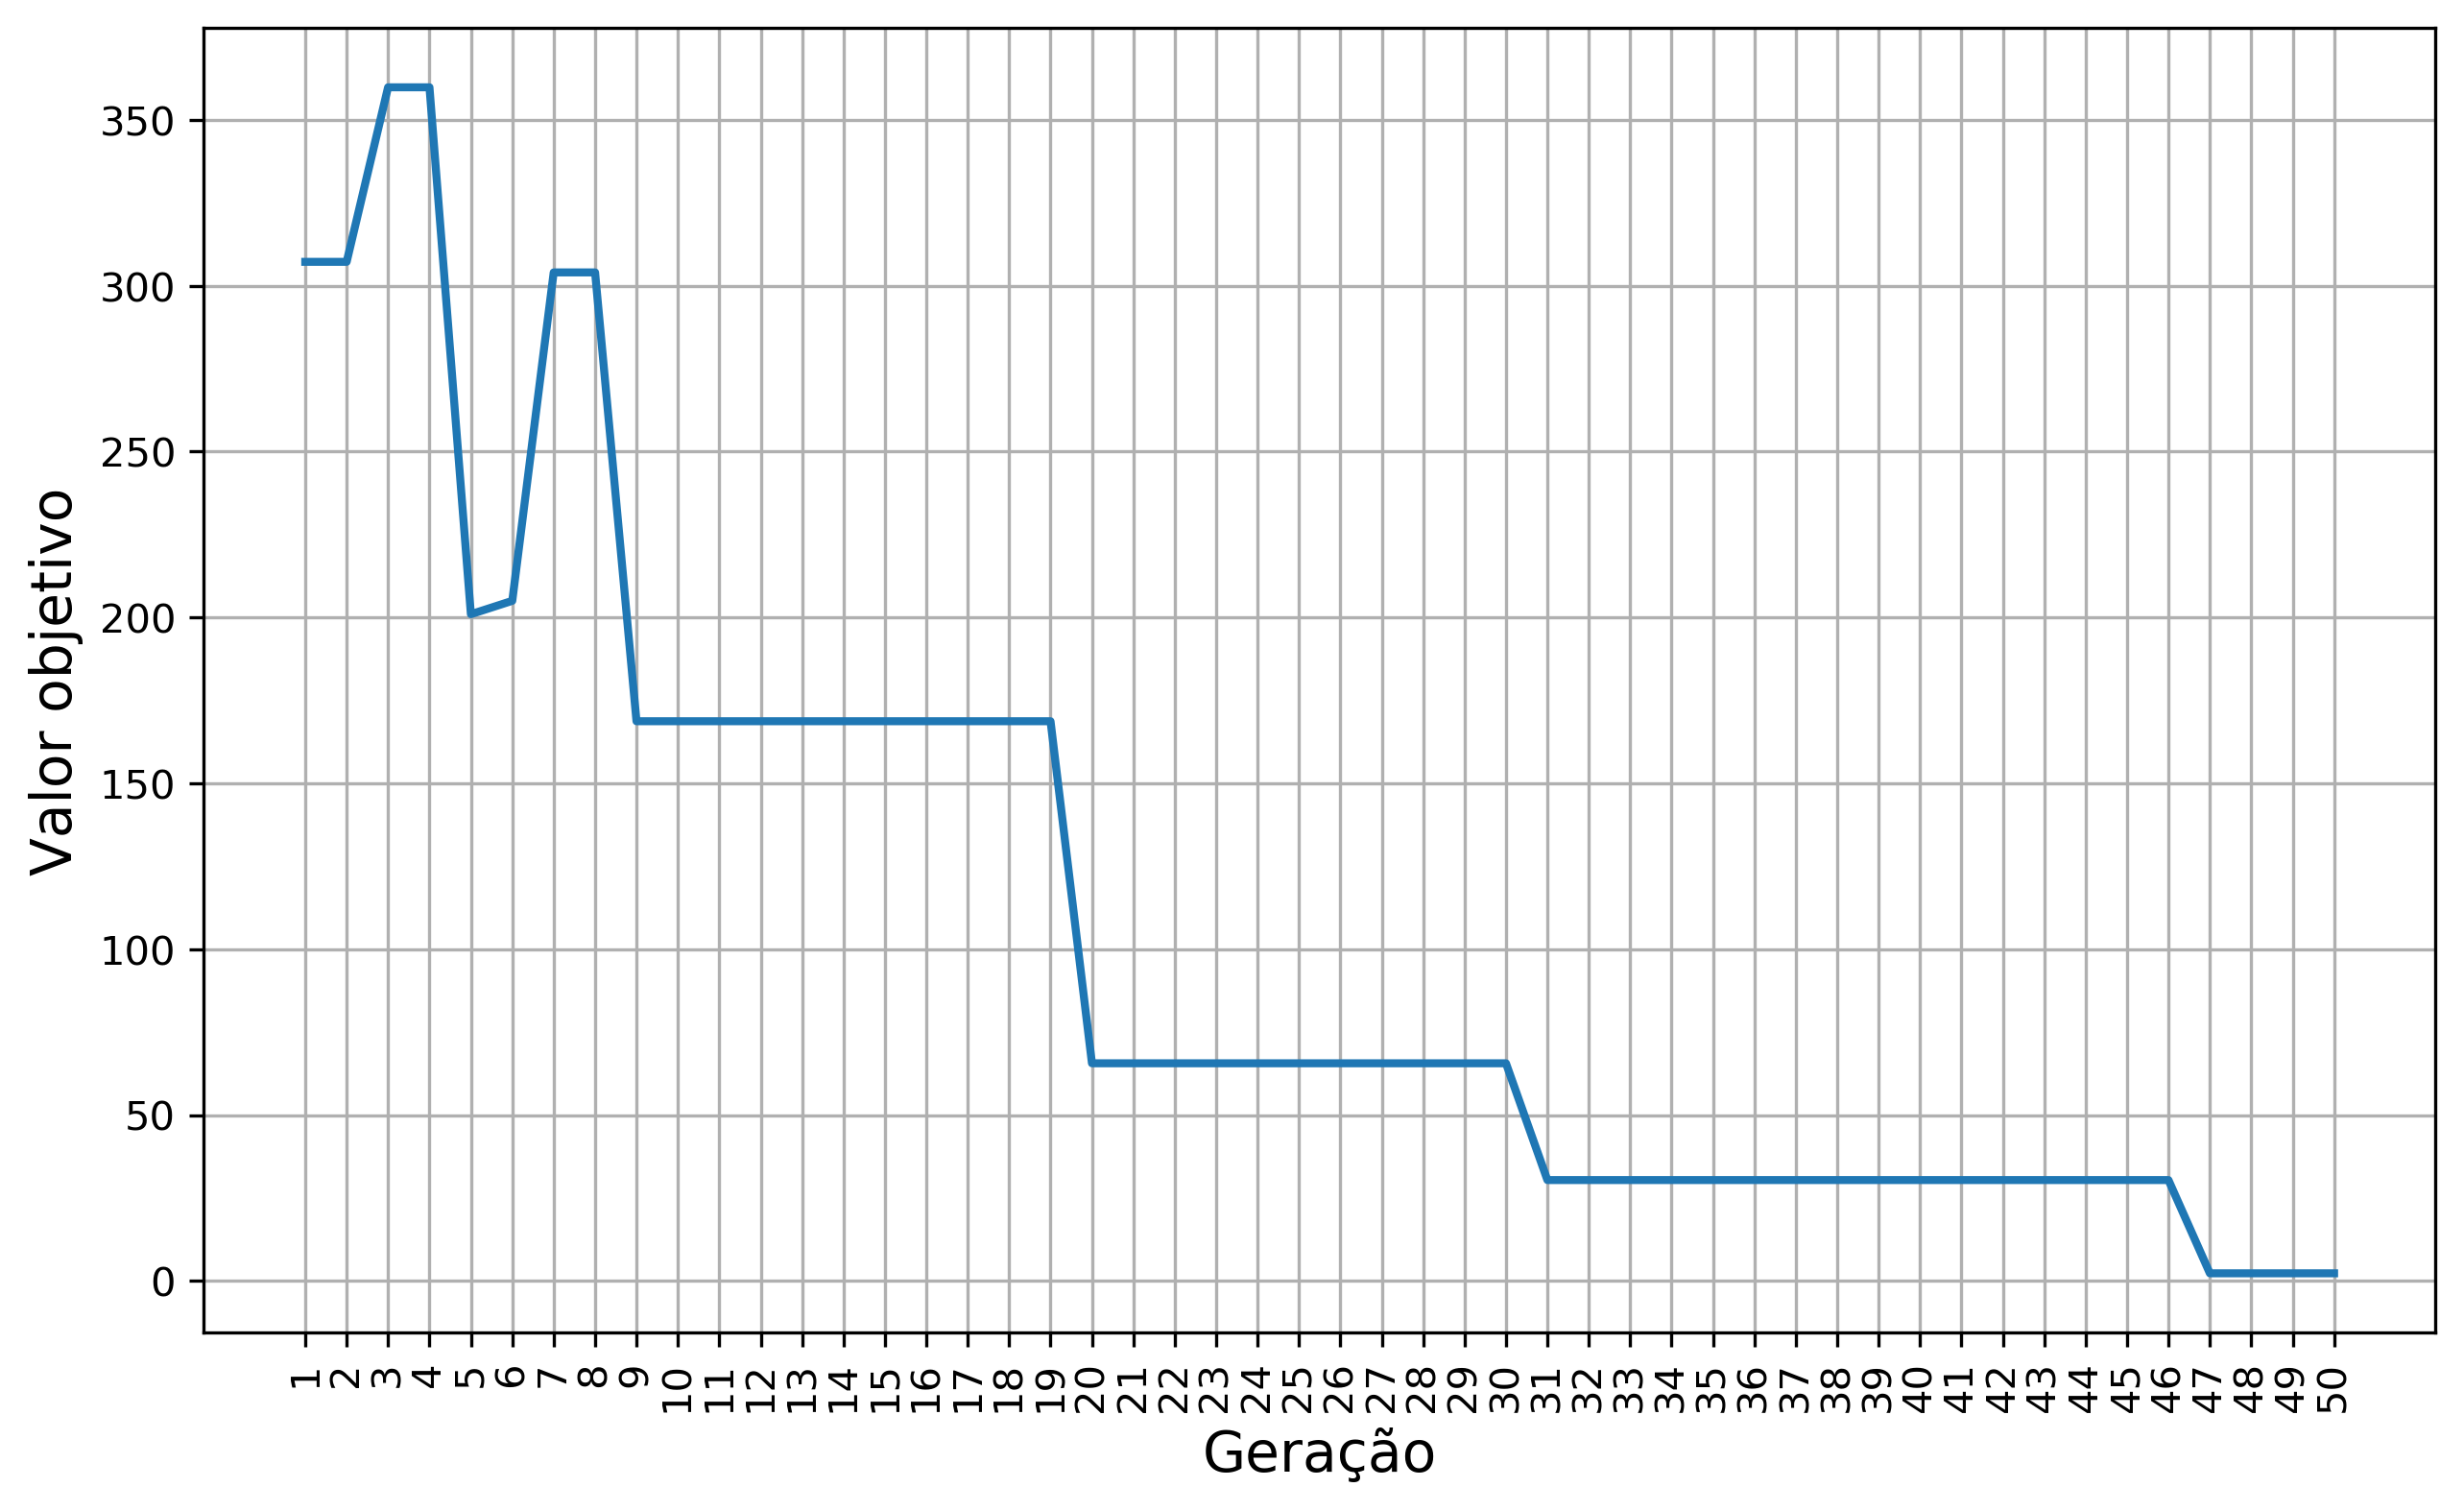

In [16]:
hist_fit_t6 = list(map(lambda x: x.valor_objetivo, populacao_t6.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t6, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Um grafico

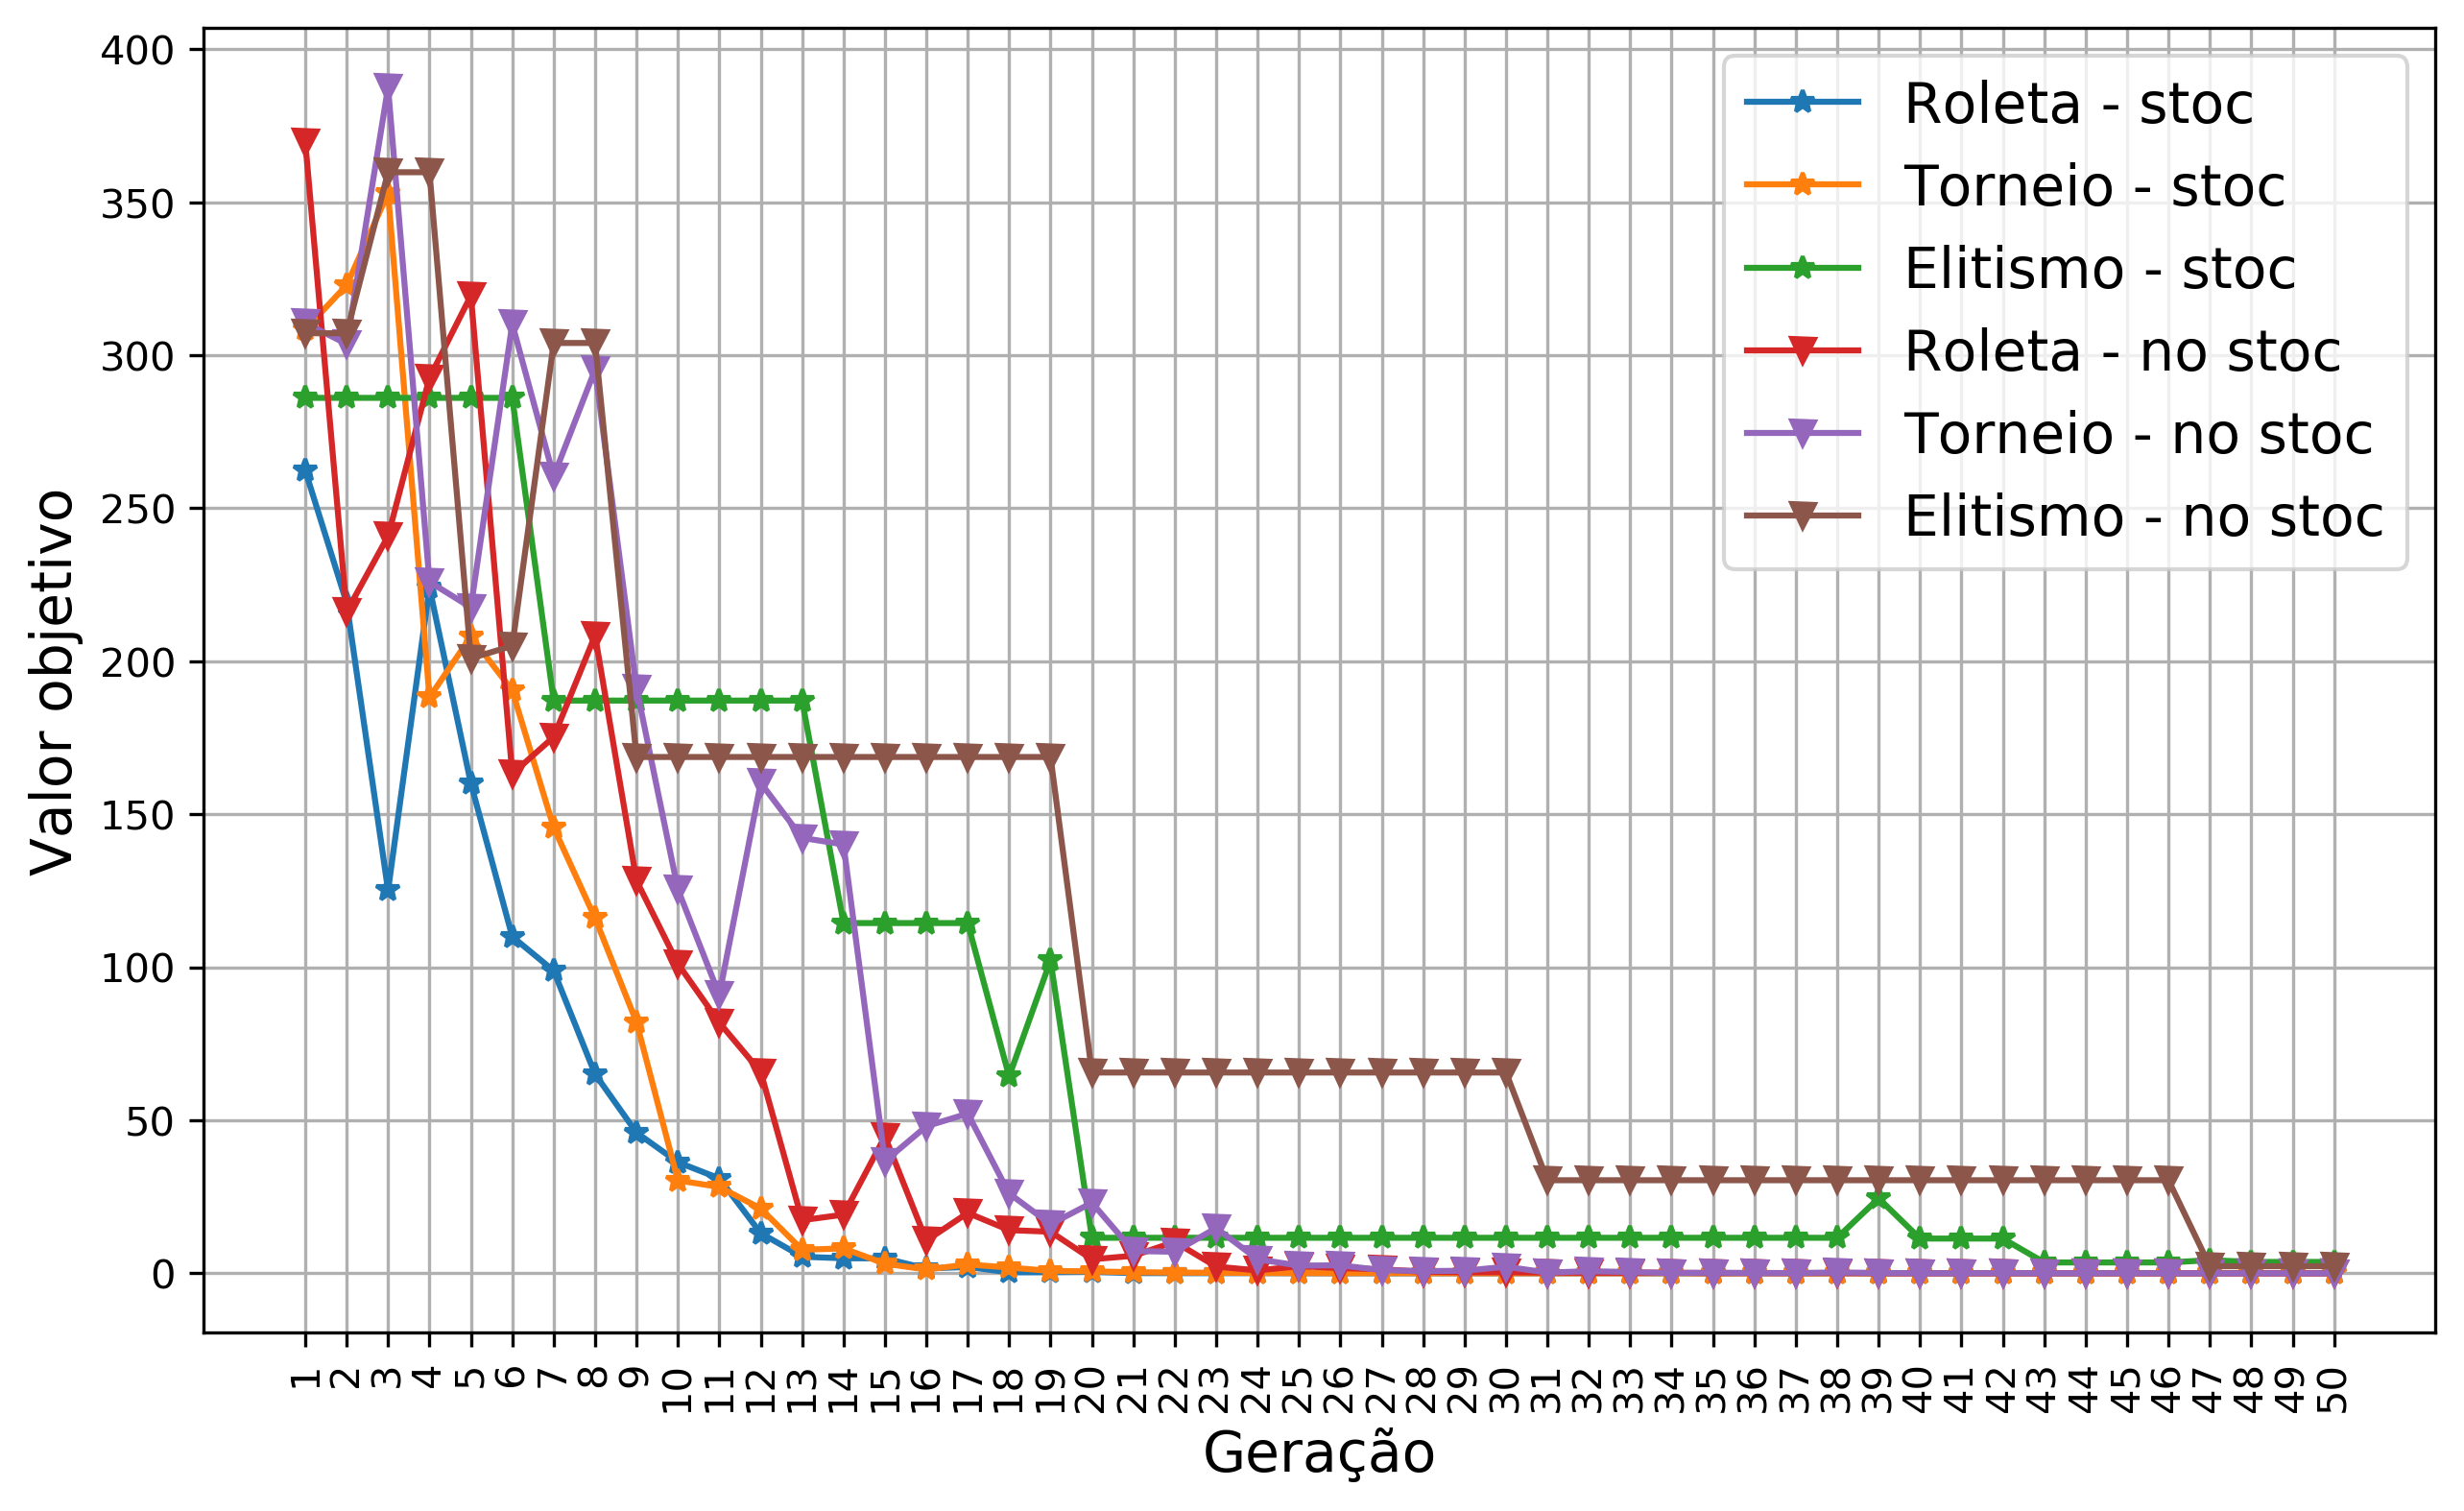

In [17]:
fig= plt.figure(figsize=(10,6), dpi=300)

plt.plot(xticks, hist_fit_t1, linewidth=1.5, marker='*', label="Roleta - stoc")
plt.plot(xticks, hist_fit_t2, linewidth=1.5, marker='*', label="Torneio - stoc")
plt.plot(xticks, hist_fit_t3, linewidth=1.5, marker='*', label="Elitismo - stoc")
plt.plot(xticks, hist_fit_t4, linewidth=1.5, marker='v', label="Roleta - no stoc")
plt.plot(xticks, hist_fit_t5, linewidth=1.5, marker='v', label="Torneio - no stoc")
plt.plot(xticks, hist_fit_t6, linewidth=1.5, marker='v', label="Elitismo - no stoc")

plt.legend(fontsize=14)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()